In [6]:
import torchvision
from torchvision import transforms
import sys
from torch.utils import data
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [7]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True,strides=2))
            else:
                blk.append(d2l.Residual(out_channels,out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())

    net.add_module("resnet_block1", resnet_block(64,64,2,first_block=True))
    net.add_module("resnet_block2", resnet_block(64,128,2))
    net.add_module("resnet_block3", resnet_block(128,256,2))
    net.add_module("resnet_block4", resnet_block(256,512,2))
    net.add_module("resnet_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))

    return net

In [8]:
net = resnet18(10)
devices = d2l.try_all_gpus()

In [9]:
def load_data_fashion_mnist(batch_size, resize=None):
    # 存储图像处理流程
    trans = []
    if resize:
        trans.append(transforms.Resize(size=resize))
    trans.append(transforms.ToTensor())
    transform = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='01_data/01_DataSet_FashionMNIST',
        train=True,
        download=True,
        transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root='01_data/01_DataSet_FashionMNIST',
                                                   train=False,
                                                   download=True,
                                                   transform=transform)
    if sys.platform.startswith('win'):
        # 0表示不用额外的进程来加速读取数据
        num_workers = 0
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter

In [10]:
# 训练
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]

    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    # nn.DataParallel会的是X切开并行到各个GPU上，并行算梯度，然后loss加起来，它重新定义了net的forward函数
    net = nn.DataParallel(net, device_ids=devices) # net会复制到每一个GPU上
    trainer = torch.optim.SGD(net.parameters(),lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch','test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
         f'on {str(devices)}')

test acc: 0.93, 44.7 sec/epochon [device(type='cuda', index=0)]


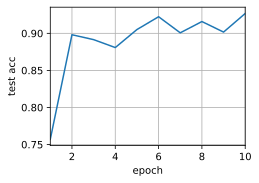

In [11]:
# 在单个GPU上训练网络
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [12]:
# 使用2个GPU进行训练
train(net, num_gpus=2, batch_size=512, lr=0.2)

ValueError: Expected a non cpu device, but got: cpu